In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import csv
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
import datetime

import os
import re
import sys
import platform
import collections
import shutil
import math
import multiprocessing
import os.path
from gensim import corpora, models
from gensim.models import Word2Vec, keyedvectors 
from gensim.models.word2vec import LineSentence
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/SrJ/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [111]:
df = pd.read_csv('Main_Dataset.csv',keep_default_na=False) #Loading saved df and Keeping N/A as it is.
ISCO = pd.read_csv('ISCOv1.csv')

In [5]:
ISCO.rename(columns={'ISCO 08 Code': 'Code', 'Title EN': 'Title'},inplace=True)

In [112]:
ISCO = ISCO[ISCO.Code.astype(str).str.len() == 4]
ISCO = ISCO.reset_index(drop=True)

In [113]:
JOB_DESC = 'Job_Responsibility'
JOB_TITLE = 'JobTitle'

In [114]:
df[JOB_DESC].fillna("",inplace=True)
df[JOB_TITLE].fillna("",inplace=True)

In [115]:
w_tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

In [116]:
tokenized_job_desc = [[w for w in w_tokenizer.tokenize(desc.lower()) if w not in stop_words] 
                                for desc in df[JOB_DESC].values]

In [117]:
tokenized_job_title = [[w for w in w_tokenizer.tokenize(title.lower()) if w not in stop_words]
                                  for title in df[JOB_TITLE].values]

In [118]:
dim_model = 300
model = Word2Vec(tokenized_job_desc + tokenized_job_title,vector_size=dim_model, window=5,
                                min_count = 5 , workers = multiprocessing.cpu_count())

In [119]:
model.init_sims(replace=True)

<ipython-input-119-dabd6e7393f0>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [120]:
word_all = model.wv

In [121]:
regex = re.compile('[^a-zA-Z0-9]')
isco_vector_list = []
for occupation in ISCO.Title.values:
    occupation = regex.sub(' ', occupation)
    tokens_occupation = [w for w in re.split(' ', occupation) if w in word_all if not w in stop_words]
    vector_to_match = np.zeros(dim_model)
    for w in tokens_occupation:
        vector_to_match += model.wv[w]
    isco_vector_list.append(vector_to_match)
        

In [122]:
occupation_list = []
integer_title = df.JobTitle.str.isnumeric()
refined_title = df[~integer_title]
refined_title = refined_title.JobTitle.values

In [123]:
from sklearn.metrics.pairwise import cosine_similarity
for title in refined_title[:10]:
    title = regex.sub(' ', title).lower()
    tokens_title = [w for w in re.split(' ', title) if w in word_all if not w in stop_words]
    matched = False
    for isco_title in ISCO.Title.values:
        if title == isco_title:
            occupation_list.append(isco_title)
            matched = True
    if matched == False:
        if tokens_title == []:
            occupation_list.append(np.nan)
        else:
            vector_title = np.zeros(dim_model)
            for w in tokens_title:
                vector_title += model.wv[w]
            list_scores = cosine_similarity(isco_vector_list,vector_title.reshape(1,-1))
            isco_index = list_scores.argmax()
            print(isco_index)
            occupation_list.append(ISCO.loc[isco_index,'Title'])


192
1527
3664
3815
175
1199
1199
6580
3813
192


In [124]:
occupation_list

['Analyst, programmer',
 'Designer, software',
 'Midwife, assistant',
 'Officer, chief information',
 'Analyst, infrastructure: systems administration',
 'Consultant, internet: helpdesk',
 'Consultant, internet: helpdesk',
 'Under-manager, mine',
 'Officer, chief executive',
 'Analyst, programmer']

In [125]:
df.JobTitle[:10]

0                       Software Engineer (PHP/ MySQL)
1                                   Software Developer
2       Deputy General Manager, Information Technology
3               Deputy Manager, Information technology
4    System Engineer/ Senior System Engineer - Core...
5         Technical Support Specialist &#8208; Telecom
6         Technical Support Specialist &#8208; Telecom
7                      Dy. Manager/ Manager, Marketing
8             Marketing Officer/ Sr. Marketing Officer
9         Full Stack Software Engineer (.NET Platform)
Name: JobTitle, dtype: object

In [40]:
title = regex.sub(' ', title).lower()
tokens_title = [w for w in re.split(' ', title) if w in word_all if not w in stop_words]
tokens_title

['technical', 'support', 'specialist', '8208', 'telecom']

In [43]:
vector_title = np.zeros(dim_model)
for w in tokens_title:
    vector_title += model.wv[w]
vector_title

array([ 2.12512577e-02, -7.17445763e-02, -6.36880398e-02, -1.97492950e-02,
       -2.81342607e-01, -1.51591673e-01, -3.42432149e-02,  2.25971603e-01,
        1.20051883e-01, -9.58232931e-02,  5.86177932e-02,  2.81881504e-01,
       -1.68359995e-01,  1.41894717e-01, -1.48126342e-01, -6.38679713e-02,
        1.86841648e-01, -1.71405569e-01, -1.04908771e-01,  1.54599602e-01,
       -2.14190053e-01,  1.23658268e-01, -1.44638992e-01,  1.89855518e-01,
       -2.05866390e-01,  3.98579245e-02,  1.21264489e-01, -3.52694288e-01,
       -2.91525118e-01, -3.88107880e-02,  9.80613753e-02, -2.74751561e-01,
        3.89285758e-01, -1.26043460e-02, -7.98212283e-03,  1.26925719e-01,
        4.97368788e-02, -2.01351058e-01,  1.38619708e-01, -1.43747074e-02,
       -4.90439343e-02,  6.67331583e-02,  4.71536219e-02, -6.42341185e-01,
       -5.17604672e-02, -1.19240915e-01,  2.01038844e-01,  1.44356892e-01,
        1.09823862e-01, -1.27879384e-01,  2.71535255e-01,  8.76493026e-02,
        1.22797970e-01,  

In [37]:
list_scores = cosine_similarity(isco_vector_list,vector_title.reshape(1,-1))
print(list_scores)
isco_index = list_scores.argmax()
occupation_list.append(ISCO.loc[isco_index,'Title'])

array([-0.03167612,  0.02839283,  0.06514344, -0.03885083, -0.07875885,
        0.03362738,  0.04249423, -0.07443641, -0.0493613 , -0.03094234,
        0.03282148,  0.04823633, -0.01335166,  0.08915211,  0.06543836,
        0.01763078,  0.01229718,  0.08516919, -0.09361503,  0.02518891,
       -0.02336526,  0.01013894,  0.02341385, -0.00521565, -0.04916027,
        0.02871258,  0.01919482, -0.05660657, -0.06278901, -0.06091828,
       -0.08740927, -0.08722337,  0.09423451, -0.1085289 , -0.00141624,
        0.01320174, -0.00034514,  0.03618912, -0.02536374, -0.0415495 ,
       -0.1109808 ,  0.05811058, -0.05436537, -0.09096322,  0.01985043,
       -0.09773125, -0.03395227,  0.09132929,  0.06005625,  0.03880861,
       -0.09321781,  0.06023803,  0.02401827,  0.03435228, -0.05330252,
       -0.08600655, -0.0599463 ,  0.01409811, -0.00254325,  0.06454241,
        0.06858546, -0.03679791,  0.01872758, -0.05867532, -0.00904436,
        0.01238469, -0.05000435, -0.02210463,  0.05527959,  0.00

In [107]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [109]:
doc1 = nlp("Software and applications developers and analysts not elsewhere classified")
doc2 = nlp(" Software Developer")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))

Software and applications developers and analysts not elsewhere classified <->  Software Developer 0.6968172189919583


In [130]:
isco_vector_list = []
for occupation in ISCO.Title.values:
    isco_vector_list.append(nlp(occupation.lower()).vector)

In [142]:
occupation_list = []
integer_title = df.JobTitle.str.isnumeric()
refined_title = df[~integer_title]
refined_title = refined_title.JobTitle.values
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
for title in tqdm(refined_title):
    title = title.lower()
    vector_title = nlp(title).vector
    list_scores = cosine_similarity(isco_vector_list,vector_title.reshape(1,-1))
    isco_index = list_scores.argmax()
#     print(isco_index)
    occupation_list.append(ISCO.loc[isco_index,'Title'])

In [143]:
len(occupation_list)

11963

In [144]:
len(refined_title)

11963

In [147]:
df['ISCO Title'] = occupation_list

In [155]:
freq = {key: value for key,value in df['ISCO Title'].value_counts().items()}
freq

{'Engineer, software': 920,
 'Developer, software': 602,
 'Programmer, computer: testing (software)': 561,
 'Developer, web': 531,
 'Assistant, computer: engineering (software support)': 451,
 'Developer, html': 430,
 'Designer, graphic': 332,
 'Developer, applications: computing (web)': 325,
 'Officer, IT support': 256,
 'Manager, IT': 195,
 'Developer, web applications': 194,
 'Programmer, html': 188,
 'Engineer, desktop support': 154,
 'Developer, applications: computing (except web)': 144,
 'Director, executive': 137,
 'Executive, account: sales (information and communications technology)': 136,
 'Developer, web software': 133,
 'Executive, account: sales (pharmaceuticals)': 132,
 'Director-general, special-interest organization': 119,
 'Programmer, computer': 114,
 'Technician, network support': 110,
 'Assistant, computer: engineering (operations)': 108,
 'Manager, release: projects (ICT)': 107,
 'Specialist, marketing': 106,
 'Developer, dhtml': 102,
 'Manager, marketing': 94,
 '

In [150]:
df.JobTitle.value_counts()

Software Engineer                                               343
Web Developer                                                   218
IT Officer                                                      150
IT Executive                                                    124
Graphic Designer                                                 94
                                                               ... 
Consultant - Website Development                                  1
Web Designer/ GUI Designer                                        1
Junior Support Specialist (IT & MIS)                              1
Network Engineer & Windows Server Administrator/ Specialist       1
Sr. Software Programmer/ Software Programmer (Japan Project)      1
Name: JobTitle, Length: 5760, dtype: int64

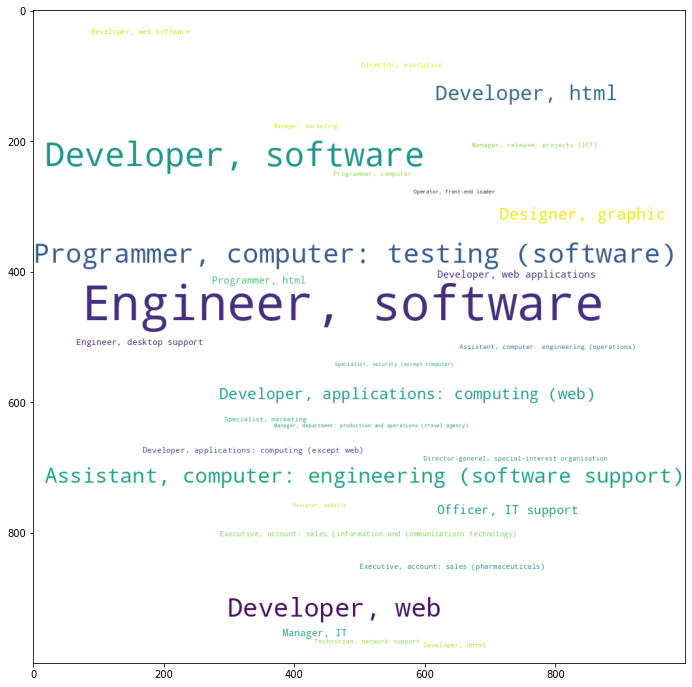

In [160]:
plt.rcParams['figure.figsize']= (12,12)
from wordcloud import WordCloud
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=30,relative_scaling=0.9,normalize_plurals=False).generate_from_frequencies(freq)
plt.imshow(wc)
plt.savefig('WordCloud.png',dpi=350)

In [164]:
df.to_csv('ISCOLabel_Dataset.csv',index=False)

In [163]:
?df.to_csv